In [2]:
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.util.pc_to_mesh import marching_cubes_mesh
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud
from point_e.util.point_cloud import PointCloud

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [4]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

In [13]:
prompt = 'a brown table with a white tablecloth'  

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

0it [00:00, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 580.00 MiB. GPU 0 has a total capacity of 3.71 GiB of which 572.38 MiB is free. Process 3864 has 69.68 MiB memory in use. Including non-PyTorch memory, this process has 3.05 GiB memory in use. Of the allocated memory 2.72 GiB is allocated by PyTorch, and 249.58 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

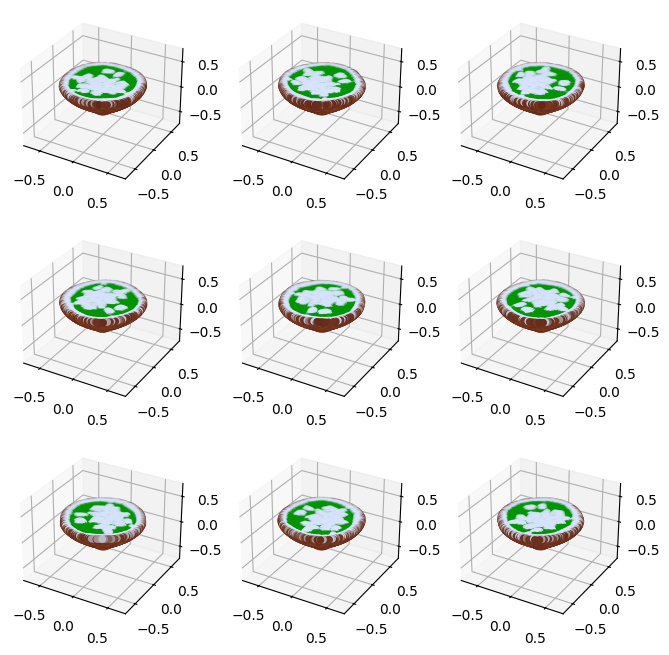

In [6]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [7]:
pc

PointCloud(coords=array([[ 0.0453767 , -0.41038346,  0.09905177],
       [ 0.2662741 , -0.41891494,  0.25479594],
       [ 0.12202955, -0.20027624,  0.2215909 ],
       ...,
       [ 0.42961144,  0.2702922 ,  0.25368223],
       [ 0.09204538, -0.2696031 ,  0.22140023],
       [-0.2704592 ,  0.17841159,  0.222577  ]],
      shape=(4096, 3), dtype=float32), channels={'R': array([0.4666667 , 0.8431373 , 0.00784314, ..., 0.79215693, 0.00392157,
       0.01176471], shape=(4096,), dtype=float32), 'G': array([0.21568629, 0.882353  , 0.5764706 , ..., 0.8117648 , 0.5803922 ,
       0.5803922 ], shape=(4096,), dtype=float32), 'B': array([0.12156864, 0.97647065, 0.01568628, ..., 0.8862746 , 0.01568628,
       0.02352941], shape=(4096,), dtype=float32)})

In [14]:
# Add this code after the point cloud (`pc`) is generated

import numpy as np
import open3d as o3d
import trimesh

coords = pc.coords
r = pc.channels['R']
g = pc.channels['G']
b = pc.channels['B']

colors = np.stack([r, g, b], axis=-1)

ply_filename = "point_cloud.ply"
print(f"Saving point cloud to {ply_filename}...")
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(coords)
pcd.colors = o3d.utility.Vector3dVector(colors)
o3d.io.write_point_cloud(ply_filename, pcd)

glb_filename = "point_cloud.glb"
print(f"Exporting point cloud to {glb_filename}...")
mesh = trimesh.points.PointCloud(coords, colors=colors)
mesh.export(glb_filename)

print("Export complete!")

Saving point cloud to point_cloud.ply...
Exporting point cloud to point_cloud.glb...
Export complete!


creating SDF model...
loading SDF model...


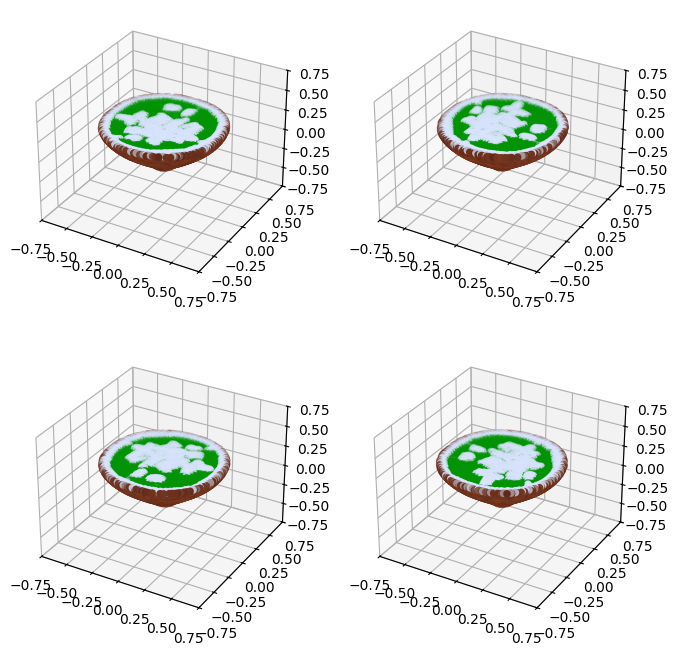

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

# pc = PointCloud.load('example_data/pc_corgi.npz')

# Plot the point cloud as a sanity check.
fig = plot_point_cloud(pc, grid_size=2)

In [10]:
mesh = marching_cubes_mesh(
    pc=pc,
    model=model,
    batch_size=4096,
    grid_size=128,
    progress=True,
)

  0%|          | 0/512 [00:00<?, ?it/s]

In [11]:
with open('mesh.ply', 'wb') as f:
    mesh.write_ply(f)

# Visualize pointcloud model using open3d

In [ ]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pc.coords)
if 'R' in pc.channels and 'G' in pc.channels and 'B' in pc.channels:
    colors = np.stack([pc.channels['R'], pc.channels['G'], pc.channels['B']], axis=-1)
    pcd.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([pcd])

# Visualize generated mesh

In [ ]:
import open3d as o3d

mesh_filename = "mesh.ply"

print(f"Loading mesh from {mesh_filename}...")
o3d_mesh = o3d.io.read_triangle_mesh(mesh_filename)

print("Visualizing the mesh...")
o3d.visualization.draw_geometries([o3d_mesh])

Loading mesh from mesh.ply...
Visualizing the mesh...


: 

In [1]:
import torch

from shap_e.diffusion.sample import sample_latents
from shap_e.diffusion.gaussian_diffusion import diffusion_from_config
from shap_e.models.download import load_model, load_config
from shap_e.util.notebooks import create_pan_cameras, decode_latent_images, gif_widget

In [2]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [3]:
xm = load_model('transmitter', device=device)
model = load_model('text300M', device=device)
diffusion = diffusion_from_config(load_config('diffusion'))

/home/mohammed/dev/interview/andazkumar/shap-e/shap_e/models/nn/checkpoint.py:31: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/home/mohammed/dev/interview/andazkumar/shap-e/shap_e/models/nn/checkpoint.py:43: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
/home/mohammed/dev/interview/andazkumar/shap-e/shap_e/models/nn/checkpoint.py:61: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/home/mohammed/dev/interview/andazkumar/shap-e/shap_e/models/nn/checkpoint.py:86: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [ ]:
batch_size = 4
guidance_scale = 15.0
prompt = "a shark"

latents = sample_latents(
    batch_size=batch_size,
    model=model,
    diffusion=diffusion,
    guidance_scale=guidance_scale,
    model_kwargs=dict(texts=[prompt] * batch_size),
    progress=True,
    clip_denoised=True,
    use_fp16=True,
    use_karras=True,
    karras_steps=64,
    sigma_min=1e-3,
    sigma_max=160,
    s_churn=0,
)

  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
render_mode = 'nerf' # you can change this to 'stf'
size = 64 # this is the size of the renders; higher values take longer to render.

cameras = create_pan_cameras(size, device)
for i, latent in enumerate(latents):
    images = decode_latent_images(xm, latent, cameras, rendering_mode=render_mode)
    display(gif_widget(images))

In [ ]:
from shap_e.util.notebooks import decode_latent_mesh

for i, latent in enumerate(latents):
    t = decode_latent_mesh(xm, latent).tri_mesh()
    with open(f'example_mesh_{i}.ply', 'wb') as f:
        t.write_ply(f)
    with open(f'example_mesh_{i}.obj', 'w') as f:
        t.write_obj(f)